#### Install required libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [53]:
! pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### read file

In [54]:
df = pd.read_csv("/content/all-data.csv", delimiter=',', encoding='latin-1', header=None)
df = df.rename(columns=lambda x: ['Sentiment', 'Sentence'][x])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4846 entries, 0 to 4845
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  4846 non-null   object
 1   Sentence   4846 non-null   object
dtypes: object(2)
memory usage: 75.8+ KB


In [55]:
df.head()

,Sentiment,Sentence
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


Let's see how each class is distributed

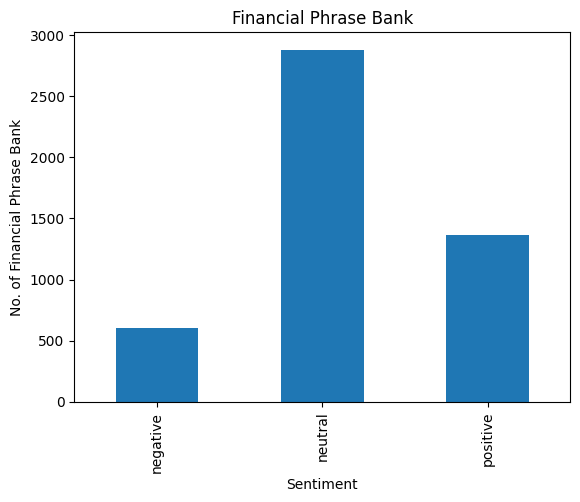

In [56]:
df_groups = df.groupby(['Sentiment'])['Sentiment'].count()

#create bar plot by group
df_groups.plot(kind='bar')
plt.xlabel("Sentiment")
plt.ylabel("No. of Financial Phrase Bank")
plt.title("Financial Phrase Bank")
plt.show()

#### Preprocess the Data

In [57]:
import re
import string
from unicodedata import normalize
import contractions


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords', quiet=True)


def preprocessing(input_text: str):
    # Convert input text to lower case
    processed_text = input_text.lower()
    
    # Expand contractions in input text
    processed_text = contractions.fix(processed_text)

    # Removes all punctuations from a string
    punctuations = string.punctuation
    processed_text = processed_text.translate(str.maketrans('', '', punctuations))

    # Remove number in the input text
    processed_text = re.sub('\d+', '', processed_text)
    
    # Removes leading, trailing, and (optionally) duplicated whitespace
    processed_text = ' '.join(re.split('\s+', processed_text.strip(), flags=re.UNICODE))
    processed_text = processed_text.strip()

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    tokens = pattern.findall(processed_text)
    processed_tokens = [token for token in tokens if token not in stop_words]

    
    return processed_tokens
    

In [58]:
df.Sentence = df.Sentence.apply(lambda x: preprocessing(x))

Remove empty sentences

In [60]:
df.drop(df.loc[df['Sentence'].str.len() == 0].index, inplace=True)

### Embeding 
use glove version 6b and dimention 300

In [61]:
def text_to_embeddings(text, embeddings, dim):
    
    words = text.split()
    embeddings_matrix = np.zeros((len(words), dim))
    for i, word in enumerate(words):
        if word in embeddings:
            embeddings_matrix[i] = embeddings[word]
    return np.mean(embeddings_matrix, axis=0)

In [62]:
embeddings = {}

with open('/content/glove.6B.300d.txt', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0] # get name : str
        vector = np.asarray(values[1:], dtype='float32') # embedding : len=300
        embeddings[word] = vector

df['Embeddings'] = df['Sentence'].apply(lambda x: text_to_embeddings(str(x), embeddings, 300)) # apply on Sentences

Train and test data should be split

In [63]:
from sklearn.model_selection import train_test_split

X = np.array(list(df['Embeddings']))
y = np.array(list(df['Sentiment']))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Define Logistic Regression as classifier

Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

#### Report scores

In [65]:
from sklearn.metrics import classification_report

y_pred = lr.predict(X_test) # inference
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.83      0.50      0.62        58
     neutral       0.76      0.89      0.82       281
    positive       0.67      0.56      0.61       146

    accuracy                           0.74       485
   macro avg       0.75      0.65      0.69       485
weighted avg       0.74      0.74      0.73       485



Naive Bayes

In [66]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB()

In [67]:
from sklearn.metrics import classification_report

y_pred = nb.predict(X_test) # inference
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

    negative       0.31      0.69      0.43        58
     neutral       0.75      0.79      0.77       281
    positive       0.56      0.22      0.32       146

    accuracy                           0.61       485
   macro avg       0.54      0.57      0.50       485
weighted avg       0.64      0.61      0.59       485

